In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\OSSI')
from KNMI_readers import read_knmi_uurgeg
from scipy.signal import welch

import puv 

In [2]:
def find_time_index(ds, specific_time):
    """
    Function to find the index 't' for a specific time in the dataset.
    
    Parameters:
    ds (xarray.Dataset): The dataset containing the time dimension.
    specific_time (str or datetime): The specific time to find the index for.
    
    Returns:
    int: The index corresponding to the specific time.
    """
    specific_time = np.datetime64(specific_time)
    time_index = np.where(ds.t.values == specific_time)[0]
    
    if len(time_index) == 0:
        raise ValueError(f"Time {specific_time} not found in the dataset.")
    
    return time_index[0]

# Example usage
# specific_time = "2024-12-20T12:00:00"
# t_index = find_time_index(ds, specific_time)
# print(f"The index for the specific time {specific_time} is {t_index}.")

In [3]:
from netCDF4 import Dataset

file_path = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\RBR\RBR_Data\tailored"

file1 = os.path.join(file_path, "RBR_06.nc")
file2 = os.path.join(file_path, "RBR_06_data2.nc")

ds = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)


c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
nc = xr.open_dataset(r"U:\2024-12-22, Storm 2\Lidars\20241223_LiDAR2\10s interval data.nc")

In [5]:
nc

<xarray.Dataset> Size: 6GB
Dimensions:      (time: 26814, string_length_t: 23, string_length_file: 42,
                  profile_number: 16, obs_number: 849)
Dimensions without coordinates: time, string_length_t, string_length_file,
                                profile_number, obs_number
Data variables:
    time_num     (time) float64 215kB ...
    time_string  (string_length_t, time) |S1 617kB ...
    file_name    (string_length_file, time) |S1 1MB ...
    x            (profile_number, obs_number, time) float32 1GB ...
    y            (profile_number, obs_number, time) float32 1GB ...
    z            (profile_number, obs_number, time) float32 1GB ...
    intensity    (profile_number, obs_number, time) float32 1GB ...

In [6]:
ds

<xarray.Dataset> Size: 422MB
Dimensions:           (t: 300, N: 28800, f: 480)
Coordinates:
  * t                 (t) datetime64[ns] 2kB 2024-12-16T09:00:00 ... 2024-12-...
  * N                 (N) float64 230kB 0.0 0.0625 0.125 ... 1.8e+03 1.8e+03
  * f                 (f) float64 4kB 0.0 0.01667 0.03333 ... 7.95 7.967 7.983
Data variables: (12/38)
    p                 (t, N) float64 69MB ...
    zi                float64 8B ...
    zb                float64 8B ...
    sf                float64 8B ...
    name              <U6 24B ...
    h                 (t) float64 2kB ...
    ...                ...
    Tm02_high         (t) float64 2kB ...
    Tmm10_high        (t) float64 2kB ...
    Tps_high          (t) float64 2kB ...
    Sk                (t) float64 2kB ...
    As                (t) float64 2kB ...
    sig               (t) float64 2kB ...
Attributes: (12/16)
    Conventions:               CF-1.6
    name:                      RBR_06
    instrument:                RBR_06
    instrument type:           Ruskin RBR Solo
    instrument serial number:  202438
    epsg:                      28992
    ...                        ...
    summary:                   Hybrid-Dune campaign, pressure corrected for a...
    contact person:            Ruben Rosman
    emailadres:                r.g.c.rosman@student.tudelft.nl
    construction datetime:     17-Feb-2025 (11:25:34)
    version:                   v1
    version comments:          constructed with xarray

In [7]:
# Create a continuous time array
t_continuous = np.array([t + np.timedelta64(int(n), 's') for t in ds.t.values for n in ds.N.values])

# Flatten the burst structure for plotting
zs_flat = ds.zs.values.flatten()
zs_low_flat = ds.zs_low.values.flatten()
zs_high_flat = ds.zs_high.values.flatten()

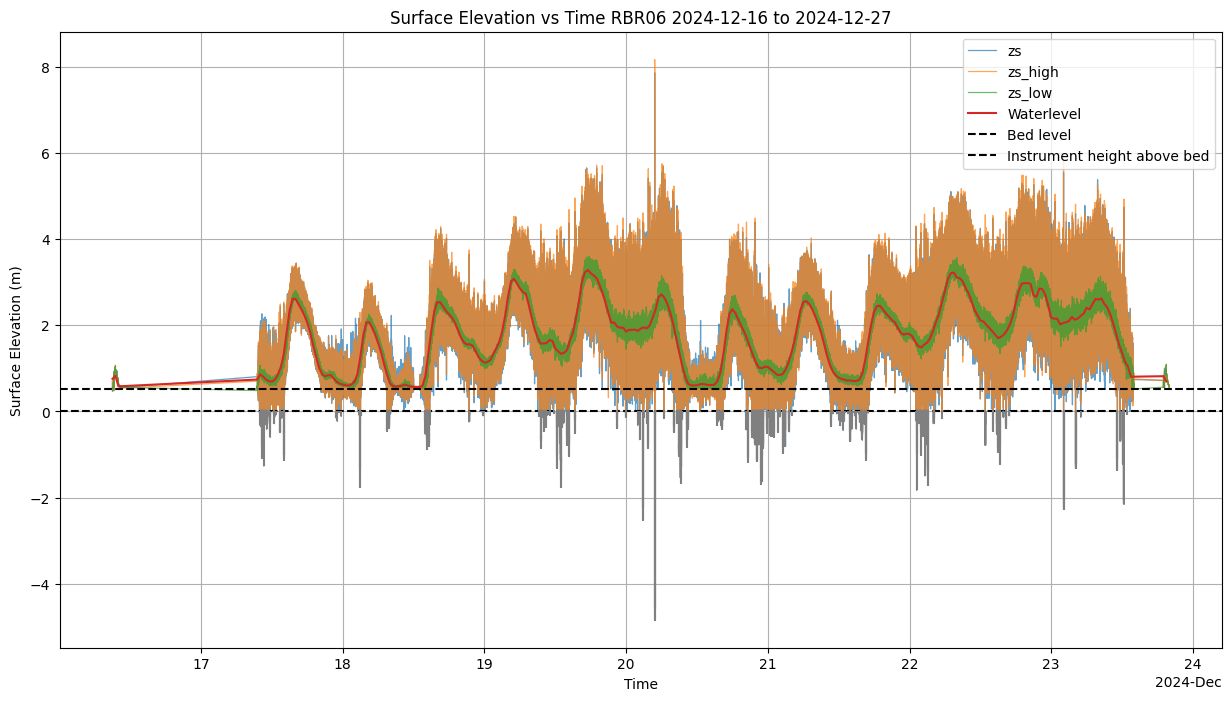

In [8]:
# Plotting
plt.figure(figsize=(15, 8))

plt.plot(t_continuous, zs_flat, label='zs', alpha=0.7, linewidth=0.9)
plt.plot(t_continuous, zs_high_flat, label='zs_high', alpha=0.7, linewidth=0.9)
plt.plot(t_continuous, zs_low_flat, label='zs_low', alpha=0.7, linewidth=0.9)

ds.h.plot(label='Waterlevel')



# give values below y=0 a different color
plt.fill_between(t_continuous, zs_flat, 0, where=zs_flat < 0, color='grey', alpha=1, zorder=4, linewidth=1.5)
plt.fill_between(t_continuous, zs_low_flat, 0, where=zs_low_flat < 0, color='grey', alpha=1, zorder=4, linewidth=1.5)
plt.fill_between(t_continuous, zs_high_flat, 0, where=zs_high_flat < 0, color='grey', alpha=1, zorder=4, linewidth=1.5)
plt.axhline(y=0, color='k', linestyle='--', label='Bed level')

# Set x-axis limits using specific date stamps
start_time = pd.Timestamp("2024-12-18T12:00:00")
end_time = pd.Timestamp("2024-12-21T00:00:00")
# plt.xlim(start_time, end_time)

plt.axhline((ds.zi-ds.zb).values, color='k', linestyle='--', label='Instrument height above bed')

plt.xlabel('Time')
plt.ylabel('Surface Elevation (m)')
plt.title('Surface Elevation vs Time RBR06 2024-12-16 to 2024-12-27')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

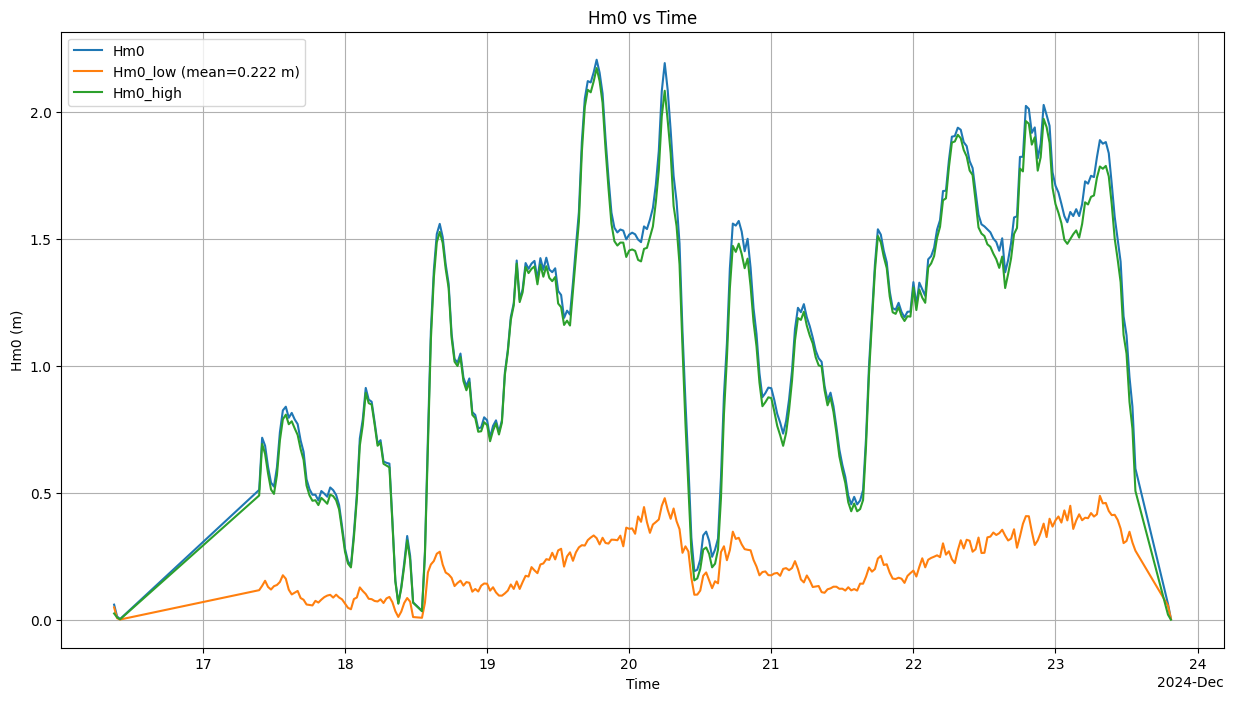

In [9]:
# plot hmo 
plt.figure(figsize=(15, 8))
ds.Hm0.plot(label='Hm0')
ds.Hm0_low.plot(label=f'Hm0_low (mean={ds.Hm0_low.mean().values:.3g} m)')

ds.Hm0_high.plot(label='Hm0_high')
plt.legend()

plt.xlabel('Time')
plt.ylabel('Hm0 (m)')
plt.title('Hm0 vs Time')
plt.grid(True)

# Set x-axis limits using specific date stamps
start_time = pd.Timestamp("2024-12-18T12:00:00")
end_time = pd.Timestamp("2024-12-21T00:00:00")
# plt.xlim(start_time, end_time)

plt.show()

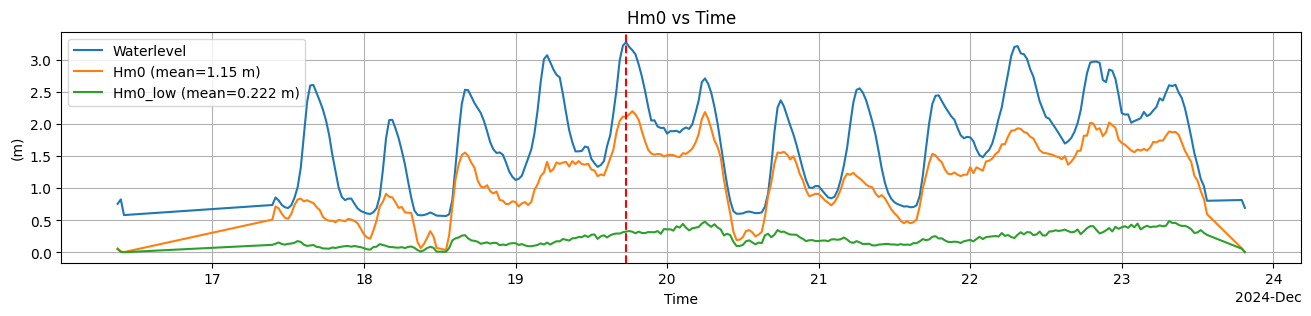

In [10]:
# plot hs and h
plt.figure(figsize=(16, 3))
ds.h.plot(label='Waterlevel')
# (ds.h + ds.zb).plot(label='Waterlevel + zb (NAP)')

# Interpolate between points
ds.Hm0.plot(label=f'Hm0 (mean={ds.Hm0.mean().values:.3g} m)')
ds.Hm0_low.plot(label=f'Hm0_low (mean={ds.Hm0_low.mean().values:.3g} m)')

# ds.Hm0_high.plot(label='Hm0_high')
plt.legend()

plt.xlabel('Time')
plt.ylabel('(m)')
plt.title('Hm0 vs Time')
plt.grid(True)

plt.axvline(x=pd.to_datetime(ds.t.values[113]), color='r', linestyle='--', label='Selected Time')
# plt.axvline(x=pd.to_datetime(ds.t.values[t]), color='b', linestyle='--', label='Selected Time (t)')
# Set x-axis limits using specific date stamps
start_time = pd.Timestamp("2024-12-21T16:00:00")
end_time = pd.Timestamp("2024-12-23T13:00:00")
# plt.xlim(start_time, end_time)

plt.show()

Note: you may need to restart the kernel to use updated packages.


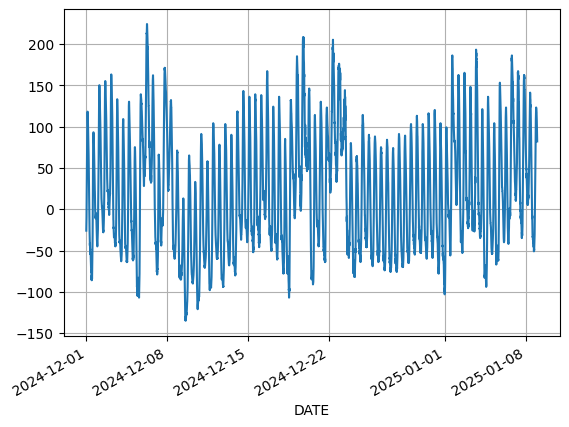

In [11]:
%pip install openpyxl

file_rws = r"U:\data RWS waterinfo\Grafieken stormen.xlsx"
df_rws = pd.read_excel(file_rws)
df_rws.head()

# read df_rws.DATE as date index
df_rws = pd.read_excel(file_rws, index_col='DATE')
df_rws.WATERLEVEL.plot()
plt.grid()

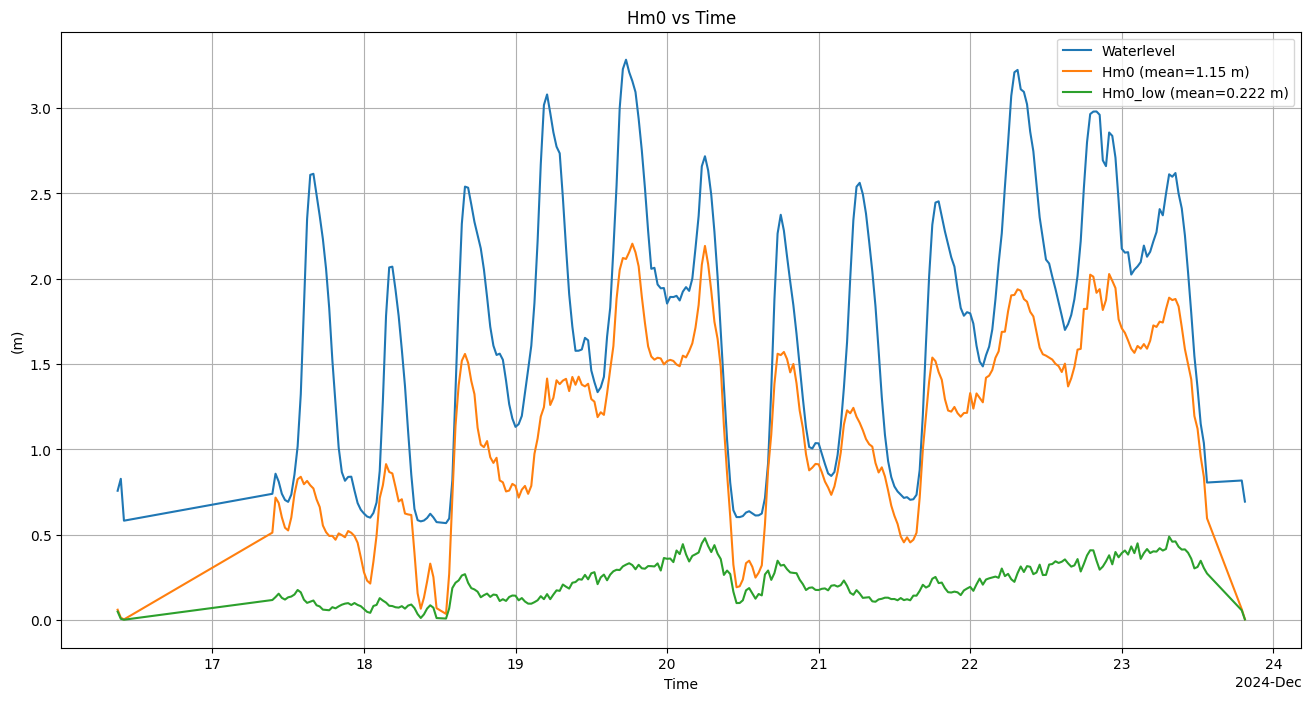

In [12]:
# plot hs and h
plt.figure(figsize=(16, 8))
ds.h.plot(label='Waterlevel')
# (ds.h + ds.zb).plot(label='Waterlevel + zb (NAP)')

# Interpolate between points
ds.Hm0.plot(label=f'Hm0 (mean={ds.Hm0.mean().values:.3g} m)')
ds.Hm0_low.plot(label=f'Hm0_low (mean={ds.Hm0_low.mean().values:.3g} m)')

# ds.Hm0_high.plot(label='Hm0_high')

plt.legend()

plt.xlabel('Time')
plt.ylabel('(m)')
plt.title('Hm0 vs Time')
plt.grid(True)



# Set x-axis limits using specific date stamps
start_time = pd.Timestamp("2024-12-21T16:00:00")
end_time = pd.Timestamp("2024-12-23T13:00:00")
# plt.xlim(start_time, end_time)

plt.show()

In [13]:
import pandas as pd

def find_highest_indices(ds, threshold=1.6):
    water_level = ds.h + ds.zb
    above_threshold = water_level > threshold

    indices = []
    current_segment = []

    for i in range(len(water_level)):
        if above_threshold[i]:
            current_segment.append(i)
        elif current_segment:
            highest_index = current_segment[pd.Series(water_level[current_segment]).idxmax()]
            indices.append(highest_index)
            current_segment = []
    
    # Check if there's a remaining segment at the end
    if current_segment:
        highest_index = current_segment[pd.Series(water_level[current_segment]).idxmax()]
        indices.append(highest_index)

    return indices


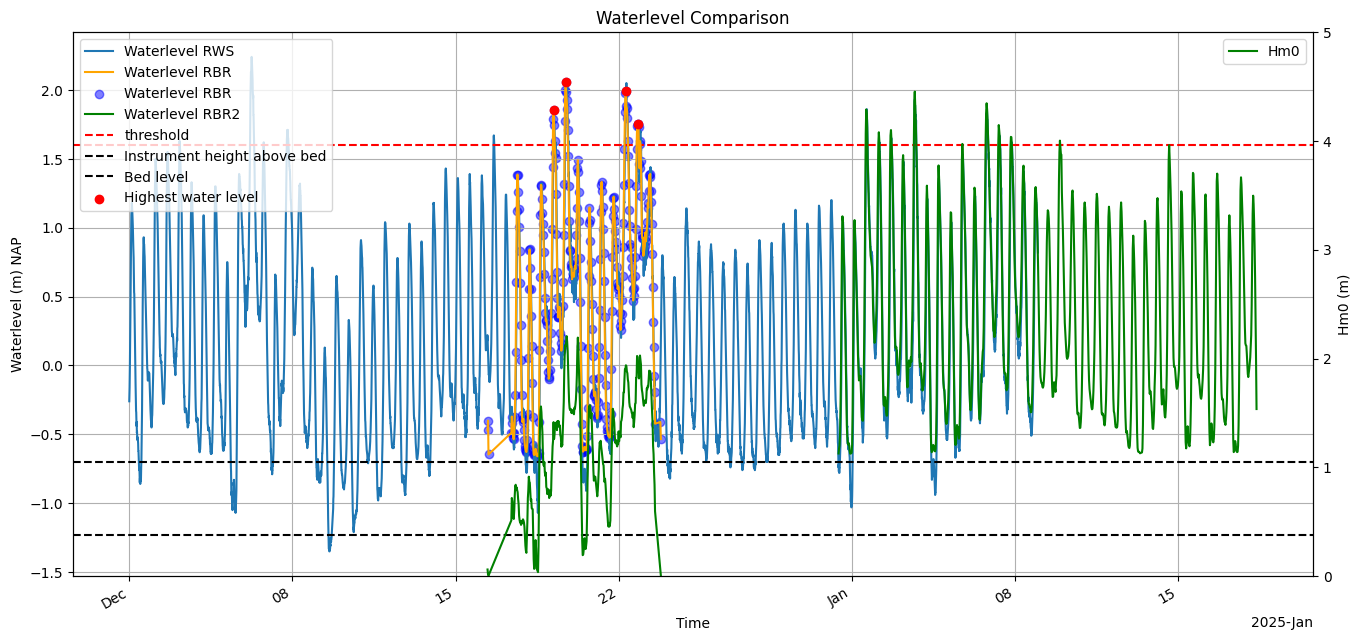

In [14]:
plt.figure(figsize=(16, 8))
highest_indices = find_highest_indices(ds, threshold=1.65)
# RWS data
(df_rws.WATERLEVEL / 100).plot(label='Waterlevel RWS')

#data 1
(ds.h + ds.zb).plot(label='Waterlevel RBR', alpha=1.0, zorder=5, color='orange')
plt.scatter(pd.to_datetime(ds.t.values), ds.h + ds.zb, color='b', label='Waterlevel RBR', alpha=0.5)

#data 2
(ds2.h + ds2.zb).plot(label='Waterlevel RBR2', alpha=1.0, zorder=5, color='green')

# axhline for threshold, instrument height and bed level
plt.axhline(y=1.6, color='r', linestyle='--', label='threshold')
plt.axhline(ds.zi, color='k', linestyle='--', label='Instrument height above bed')
plt.axhline(ds.zb, color='k', linestyle='--', label='Bed level')

# scatter above threshold
plt.scatter(pd.to_datetime(ds.t.values[highest_indices]), (ds.h + ds.zb)[highest_indices], color='r', label='Highest water level', zorder=5)
plt.legend(loc='upper left')


# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Waterlevel (m) NAP')
plt.title('Waterlevel Comparison')
plt.legend(loc='upper left')
plt.grid(True)

# Set x-axis limits using specific date stamps
start_time = pd.Timestamp("2024-12-17T16:00:00")
end_time = pd.Timestamp("2024-12-23T13:00:00")
# plt.xlim(start_time, end_time)

# plot on different axis ds.Hm0 
ax2 = plt.twinx()
ds.Hm0.plot(ax=ax2, color='g', label='Hm0')
ax2.set_ylim(0, 5)
plt.ylabel('Hm0 (m)')
plt.legend(loc='upper right')
plt.show()

[88, 113, 237, 262] [57, 83, 108, 157, 305, 330, 355]


<Figure size 1600x800 with 0 Axes>

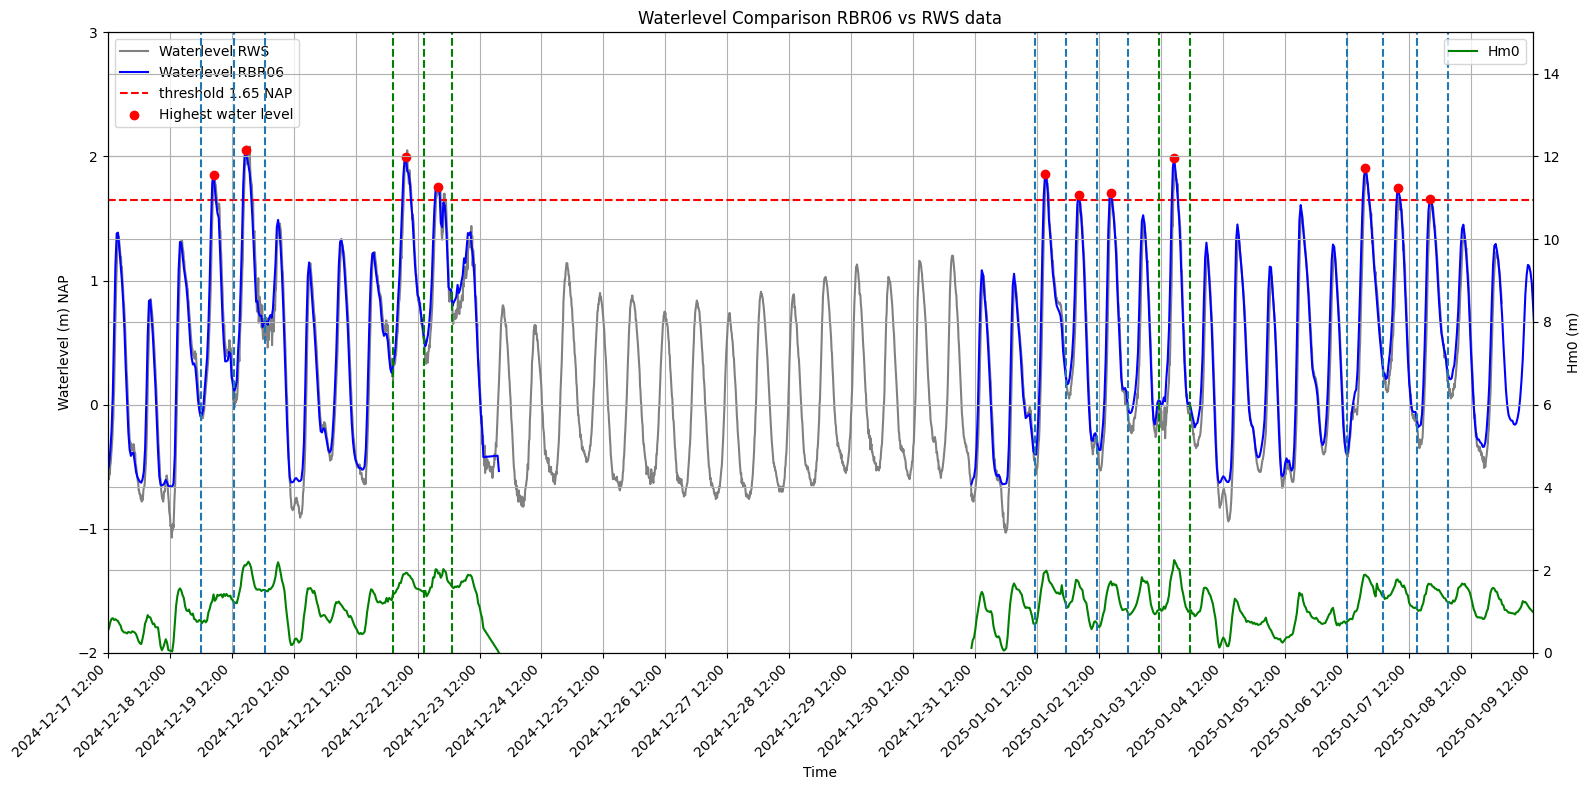

In [19]:
plt.figure(figsize=(16, 8))
# Set x-axis limits using specific date stamps
start_time = pd.Timestamp("2024-12-17T12:00:00")
end_time = pd.Timestamp("2025-01-09T12:00:00")

plt.figure(figsize=(16, 8))

highest_indices = find_highest_indices(ds, threshold=1.65)
highest_indices2 = find_highest_indices(ds2, threshold=1.65)
print(highest_indices, highest_indices2)

# RWS data
(df_rws.WATERLEVEL / 100).plot(label='Waterlevel RWS', color='grey')

# data 1
(ds.h + ds.zb).plot(alpha=1.0, zorder=5, color='blue')

# data 2
(ds2.h + ds2.zb).plot(label='Waterlevel RBR06', alpha=1.0, zorder=5, color='blue')

# # axhline for threshold, instrument height and bed level
plt.axhline(y=1.65, color='r', linestyle='--', label='threshold 1.65 NAP')

# # scatter above threshold
plt.scatter(pd.to_datetime(ds.t.values[highest_indices]), (ds.h + ds.zb)[highest_indices], color='r', label='Highest water level', zorder=5)
plt.scatter(pd.to_datetime(ds2.t.values[highest_indices2]), (ds2.h + ds2.zb)[highest_indices2], color='r', zorder=5)
plt.legend(loc='upper left')

# Add labels and legend
plt.ylim(-2, 3.0)
plt.xlabel('Time')
plt.ylabel('Waterlevel (m) NAP')
plt.title('Waterlevel Comparison RBR06 vs RWS data')
plt.legend(loc='upper left')

# Set xticks to show every 12 hours
ticks = pd.date_range(start=start_time, end=end_time, freq='12h')
plt.xticks(ticks=ticks, rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
plt.grid(True)

### plot on different axis ds.Hm0 ###
ax2 = plt.twinx()
ds.Hm0.plot(ax=ax2, color='g', label='Hm0')
ds2.Hm0.plot(ax=ax2, color='g')
ax2.set_ylim(0, 15)
plt.ylabel('Hm0 (m)')
plt.legend(loc='upper right')

# Set x-axis limits using specific date stamps
plt.xlim(start_time, end_time)

# Set xticks to show every 12 hours
ticks = pd.date_range(start=start_time, end=end_time, freq='24h')
plt.xticks(ticks=ticks, rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
plt.grid(True)

# plot axvline for lidar moment
lidarplots1 = [pd.Timestamp("2024-12-19T00:00:00"), pd.Timestamp("2024-12-19T13:00:00"), pd.Timestamp("2024-12-20T01:00:00")]
for lidarplot in lidarplots1:
	plt.axvline(x=lidarplot, linestyle='--')
	
lidarplots2 = [pd.Timestamp("2024-12-22T02:30:00"), pd.Timestamp("2024-12-22T14:30:00"), pd.Timestamp("2024-12-23T01:30:00")]
for lidarplot in lidarplots2:
	plt.axvline(x=lidarplot, linestyle='--', color='green')
	
lidarplots3 = [pd.Timestamp("2025-01-01T11:00:00"), pd.Timestamp("2025-01-01T23:00:00"), pd.Timestamp("2025-01-02T11:00:00"), pd.Timestamp("2025-01-02T23:00:00")]
for lidarplot in lidarplots3:
	plt.axvline(x=lidarplot, linestyle='--')

lidarplots4 = [pd.Timestamp("2025-01-03T11:00:00"), pd.Timestamp("2025-01-03T23:00:00")]
for lidarplot in lidarplots4:
	plt.axvline(x=lidarplot, linestyle='--', color='green')

lidarplots5 = [pd.Timestamp("2025-01-06T12:00:00"), pd.Timestamp("2025-01-07T02:00:00"), pd.Timestamp("2025-01-07T15:00:00"), pd.Timestamp("2025-01-08T03:00:00")]
for lidarplot in lidarplots5:
	plt.axvline(x=lidarplot, linestyle='--')

# legend and show
plt.tight_layout()
plt.show();

In [21]:
print(f'storm 1 has plot dates: {lidarplots1}')
print()
print(f'storm 2 has plot dates: {lidarplots2}')
print()
print(f'storm 3 has plot dates: {lidarplots3}')
print()
print(f'storm 5 has plot dates: {lidarplots5}')

storm 1 has plot dates: [Timestamp('2024-12-19 00:00:00'), Timestamp('2024-12-19 13:00:00'), Timestamp('2024-12-20 01:00:00')]

storm 2 has plot dates: [Timestamp('2024-12-22 02:30:00'), Timestamp('2024-12-22 14:30:00'), Timestamp('2024-12-23 01:30:00')]

storm 3 has plot dates: [Timestamp('2025-01-01 11:00:00'), Timestamp('2025-01-01 23:00:00'), Timestamp('2025-01-02 11:00:00'), Timestamp('2025-01-02 23:00:00')]

storm 5 has plot dates: [Timestamp('2025-01-06 12:00:00'), Timestamp('2025-01-07 02:00:00'), Timestamp('2025-01-07 15:00:00'), Timestamp('2025-01-08 03:00:00')]


In [ ]:
print(f'Hm0 is {ds.Hm0[highest_indices].values}')
print(f'Hm0 is {ds2.Hm0[highest_indices2].values}')
print()
print(f'Tp is {ds.Tp[highest_indices].values}')
print(f'Tp is {ds2.Tp[highest_indices2].values}')
print()
print(f'h is {(ds.h+ds.zb)[highest_indices].values} NAP')
print(f'h is {(ds2.h+ds.zb)[highest_indices2].values} NAP')

Hm0 is [1.41564634 2.1162968  1.93837426 1.91796791]
Hm0 is [1.95504548 1.71002384 1.73067438 2.24488618 1.89252985 1.77966667
 1.65660067]

Tp is [6.         7.5        7.5        8.57142857]
Tp is [ 8.57142857  7.5         7.5        10.          7.5         8.57142857
 12.        ]

h is [1.85088723 2.05443165 1.99470394 1.75133007] NAP
h is [1.85832052 1.69275004 1.70876891 1.98780716 1.90332224 1.74509366
 1.6593499 ] NAP


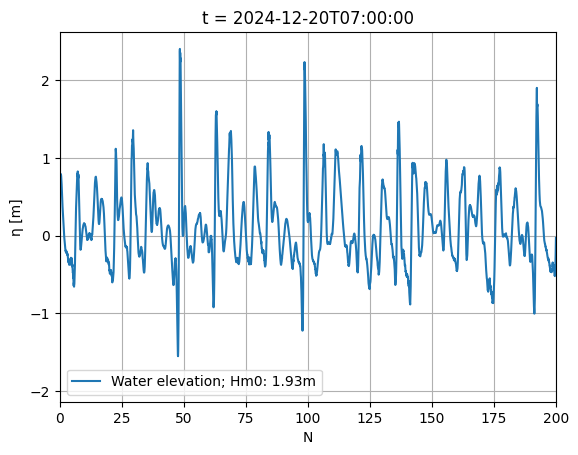

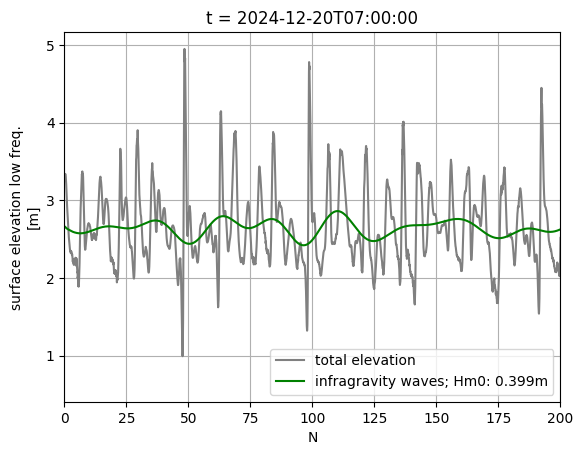

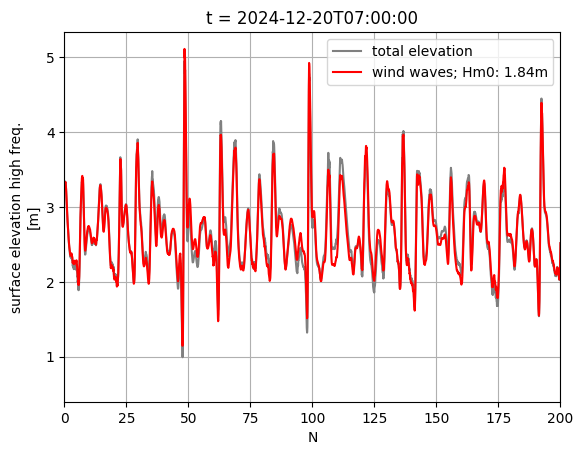

In [ ]:
t = 140
end =200

plt.figure()
(ds.zs.isel(t=t)-ds.zs.isel(t=t).mean()).plot(label = f'Water elevation; Hm0: {ds.Hm0.isel(t=t).values:.3g}m')
# (ds.zs.isel(t=t)-ds.h.isel(t=t).mean()).plot(label = f'Water elevation; Hm0: {ds.Hm0.isel(t=t).values:.3g}m')
plt.grid()
plt.xlim(0,end)
plt.ylabel(f'\u03B7 [m]')
plt.legend()

plt.figure()
ds.zs.isel(t=t).plot(color='grey', label= 'total elevation')
ds.zs_low.isel(t=t).plot(color='green', label = f'infragravity waves; Hm0: {ds.Hm0_low.isel(t=t).values:.3g}m')
plt.grid()
plt.xlim(0,end)
plt.legend()

plt.figure()
ds.zs.isel(t=t).plot(color='grey', label= 'total elevation')
ds.zs_high.isel(t=t).plot(color='red', label = f'wind waves; Hm0: {ds.Hm0_high.isel(t=t).values:.3g}m')

plt.grid()
plt.xlim(0,end)
plt.legend();

fresolution is: 0.016666666666666666


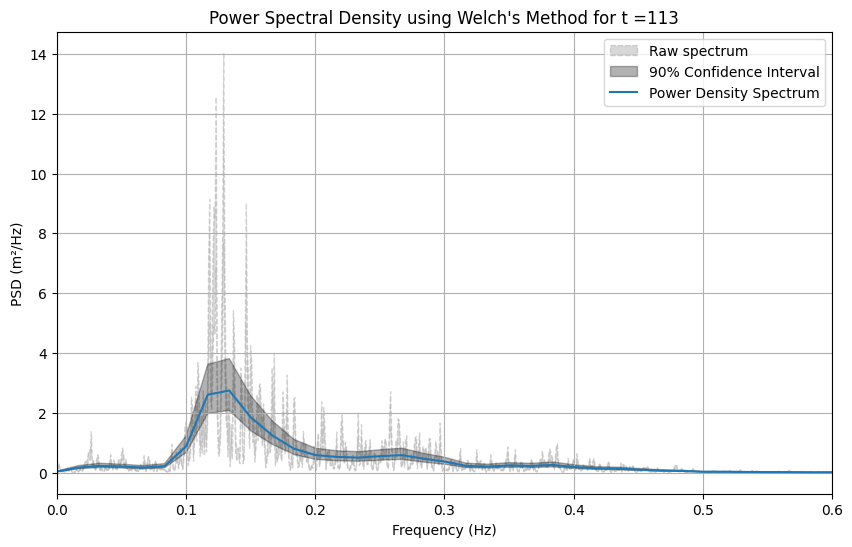

In [ ]:
from scipy.stats import chi2

### delta_f = p_blocks/D_timeframe ###
sf = 16
p_blocks = 30
D_length = 1800
fresolution = p_blocks / D_length
print(f'fresolution is: {fresolution}')
nperseg = D_length * sf / p_blocks - 0.5 #dim should be len(ds.f); whelch has (nperseg/2 +1)

plt.figure(figsize=(10, 6))
t=113
freq = ds.frequencies.isel(t=t)
psd = ds.psd.isel(t=t)


# Calculate confidence intervals
nBlocks = len(ds.zs.isel(t=t)) // nperseg  # Estimate the number of blocks used by Welch's method
edf = round(nBlocks * 2)     # Degrees of freedom (approximately 2 per segment)
alpha = 0.1                  # 90% confidence level

confLow = edf / chi2.ppf(1 - alpha / 2, edf)  # Lower confidence limit
confUpper = edf / chi2.ppf(alpha / 2, edf)    # Upper confidence limit

# Confidence interval bounds for PSD
psd_lower = psd * confLow
psd_upper = psd * confUpper



### background plot 
freq_bg, psd_bg = welch(ds.zs.isel(t=t).values, fs=16, nperseg=19200, detrend='constant', window='hann')
nBlocks_bg = len(ds.zs.isel(t=t).values) // 19200  # Estimate the number of blocks used by Welch's method
edf_bg = round(nBlocks * 2)     # Degrees of freedom (approximately 2 per segment)
confLow_bg = edf / chi2.ppf(1 - alpha / 2, edf)  # Lower confidence limit
confUpper_bg = edf / chi2.ppf(alpha / 2, edf)    # Upper confidence limit
psd_lower_bg = psd_bg * confLow_bg
psd_upper_bg = psd_bg * confUpper_bg
# plt.plot(freq_bg, psd_upper_bg, color='gray', linestyle= '--')
plt.fill_between(freq_bg, psd_lower_bg, psd_upper_bg, color='gray', alpha=0.3, label='Raw spectrum', linestyle='--')

### plotting
plt.fill_between(freq, psd_lower, psd_upper, color='black', alpha=0.3, label='90% Confidence Interval')
plt.semilogy(freq, psd, label='Power Density Spectrum')

plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.title(f'Power Spectral Density using Welch\'s Method for t ={t}')
plt.grid()
plt.yscale('linear')
# plt.xscale('log')
plt.xscale('linear')
plt.xlim(0,0.6)
plt.legend()
plt.show()

In [ ]:
# print max Hm0 value between 2024-12-21T16:00:00" and "2024-12-23T13:00:00"
t1 = find_time_index(ds, "2024-12-21T16:00:00")
t2 = find_time_index(ds, "2024-12-23T13:00:00")
Hm0_max = ds.Hm0.isel(t=slice(t1, t2)).max().values
print(f"The maximum Hm0 value between 2024-12-21T16:00:00 and 2024-12-23T13:00:00 is {Hm0_max:.3g} m.")

The maximum Hm0 value between 2024-12-21T16:00:00 and 2024-12-23T13:00:00 is 2.03 m.


In [ ]:
ds

<xarray.Dataset> Size: 422MB
Dimensions:           (t: 300, N: 28800, f: 480)
Coordinates:
  * t                 (t) datetime64[ns] 2kB 2024-12-16T09:00:00 ... 2024-12-...
  * N                 (N) float64 230kB 0.0 0.0625 0.125 ... 1.8e+03 1.8e+03
  * f                 (f) float64 4kB 0.0 0.01667 0.03333 ... 7.95 7.967 7.983
Data variables: (12/38)
    p                 (t, N) float64 69MB ...
    zi                float64 8B ...
    zb                float64 8B ...
    sf                float64 8B ...
    name              <U6 24B ...
    h                 (t) float64 2kB ...
    ...                ...
    Tm02_high         (t) float64 2kB ...
    Tmm10_high        (t) float64 2kB ...
    Tps_high          (t) float64 2kB ...
    Sk                (t) float64 2kB ...
    As                (t) float64 2kB ...
    sig               (t) float64 2kB ...
Attributes: (12/16)
    Conventions:               CF-1.6
    name:                      RBR_06
    instrument:                RBR_06
    instrument type:           Ruskin RBR Solo
    instrument serial number:  202438
    epsg:                      28992
    ...                        ...
    summary:                   Hybrid-Dune campaign, pressure corrected for a...
    contact person:            Ruben Rosman
    emailadres:                r.g.c.rosman@student.tudelft.nl
    construction datetime:     17-Feb-2025 (11:25:34)
    version:                   v1
    version comments:          constructed with xarray